In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras.layers import *
from tensorflow import keras
import numpy as np
import PIL.ImageOps

Download the caltech_birds2010 dataset

In [2]:
dataset, info = tfds.load('CaltechBirds2010:0.*.*', with_info=True)

# **U_NET:**

# Preprocessing data


In [3]:
info

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#### put image size ###

image_size = 256

In [ ]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [ ]:
@tf.function
def load_image_train(datapoint):
    #Resize

    input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
    input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
    if tf.random.uniform(()) > 0.5:
        #### put your code ###
        
        # flip images from right to left
        input_image = tf.image.flip_left_right(input_image)
        input_mamsk = tf.image.flip_left_right(input_mask)

        # Flip images from up to down
        input_image = tf.image.flip_up_down(input_image)
        input_mask = tf.image.flip_up_down(input_mask)

        # adjust brightness image with delta = 0.5
        input_image = tf.image.adjust_brightness(input_image,delta = 0.5)
        input_mask = tf.image.adjust_brightness(input_mask,delta = 0.5)

        # central crop image with value = 0.5
        inut_image = tf.image.central_crop(input_image,central_fraction = 0.5)
        inut_mask = tf.image.central_crop(input_mask,central_fraction = 0.5)

        # resize 
        input_image = tf.image.resize(input_image,[image_size,image_size])
        input_mask = tf.image.resize(input_mask,[image_size,image_size])


    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
    #Resize

    input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
    input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

train_dataset

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

In [ ]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

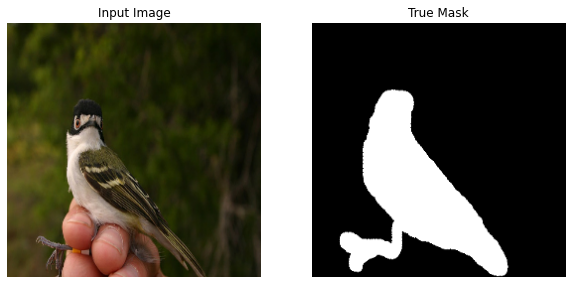

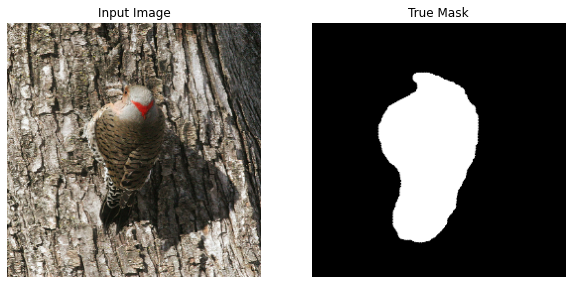

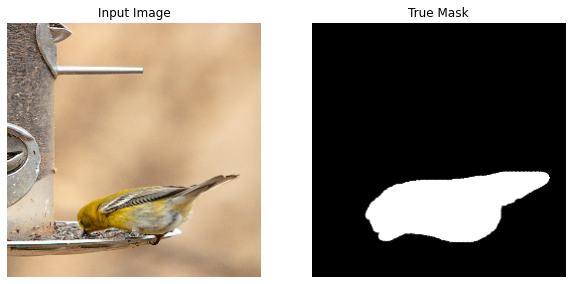

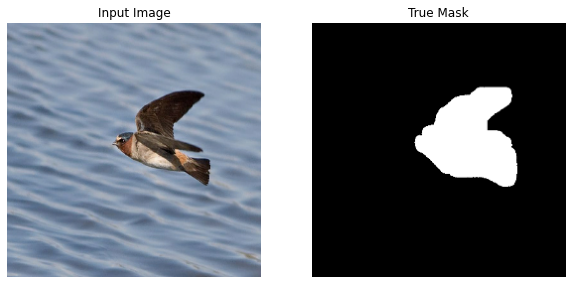

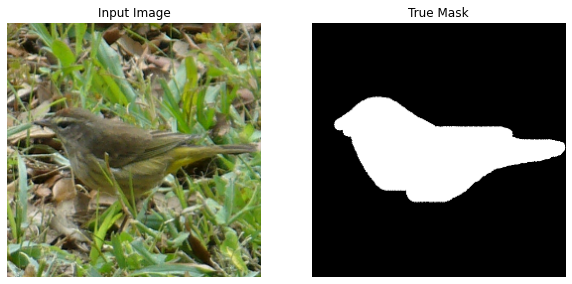

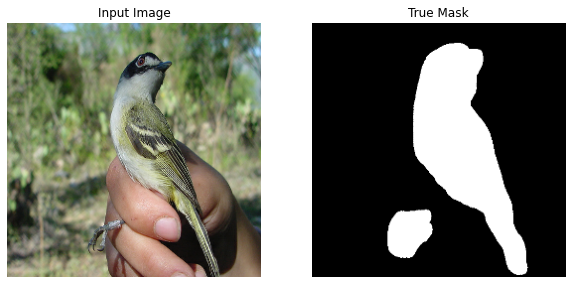

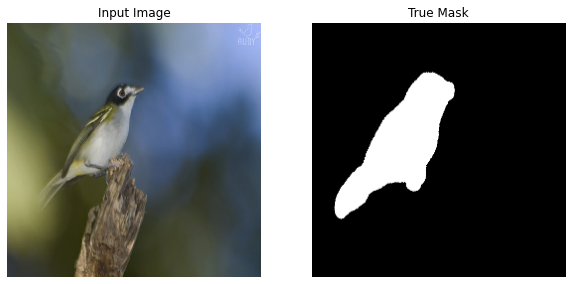

In [ ]:
for image, mask in train.take(7):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# U-net architecture

Encoder | Bottleneck | Decoder
--- | --- | ---
START:| | TS(1,4,2)
CL(32,4,2) |  | TBR(32,4,2)
CBL(64,4,2) |  | TBDR(64,4,2)
CBL(128,4,2) |  | TBR(128,4,2)
CBL(256,4,2) |  | TBDR(256,4,2)
CBL(512,4,2) | CR(512,4,2) | TBDR(512,4,2)


 Acronyms: C=convolution, B=batch normalization, L= leaky relu(alpha=0.1.5), D=dropout, R=relu,
T=transpose convolution, S=sigmoid. 

The numbers in parentheses indicate the number of ﬁlters, ﬁlter size, and stride of the convolution
ﬁlters, respectively.

Initialize weights with mean=0 and Standard deviation=0.02

You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/

# U-Net Implementation from Base

In [ ]:
from keras.activations import sigmoid
Initializer = keras.initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
# define an U_Net

inputs = Input(shape=(image_size,image_size,3))


########## Encoder ##########
Conv2D_1 = Conv2D(filters=32,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(inputs)
Activation_1 = LeakyReLU(alpha=0.15)(Conv2D_1)

Conv2D_2 = Conv2D(filters=64,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_1)
Batch_1 = BatchNormalization()(Conv2D_2)
Activation_2 = LeakyReLU(alpha=0.15)(Batch_1)

Conv2D_3 = Conv2D(filters=128,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_2)
Batch_2 = BatchNormalization()(Conv2D_3)
Activation_3 = LeakyReLU(alpha=0.15)(Batch_2)

Conv2D_4 = Conv2D(filters=256,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_3)
Batch_3 = BatchNormalization()(Conv2D_4)
Activation_4 = LeakyReLU(alpha=0.15)(Batch_3)

Conv2D_5 = Conv2D(filters=512,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_4)
Batch_4 = BatchNormalization()(Conv2D_5)
Activation_5 = LeakyReLU(alpha=0.15)(Batch_4)

########## Bottleneck ##########
Conv2D_6 = Conv2D(filters=512,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_5)
Activation_6 = ReLU()(Conv2D_6)

########## Decoder ##########
Conv2D_Trans_1 = Conv2DTranspose(filters=512,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_6)
Batch_5 = BatchNormalization()(Conv2D_Trans_1)

#merge_1 = concatenate([Conv2D_5,Conv2D_Trans_1],axis = 3)
merge_1 = add([Conv2D_5,Conv2D_Trans_1])

#Drop_1 = Dropout(rate = 0.5)(Batch_5)
Drop_1 = Dropout(rate = 0.5)(merge_1)
Activation_7 = ReLU()(Drop_1)

Conv2D_Trans_2 = Conv2DTranspose(filters=256,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_7)
Batch_6 = BatchNormalization()(Conv2D_Trans_2)

#merge_2 = concatenate([Conv2D_4,Conv2D_Trans_2],axis = 3)
merge_2 = add([Conv2D_4,Conv2D_Trans_2])

#Drop_2 = Dropout(rate = 0.5)(Batch_6)
Drop_2 = Dropout(rate = 0.5)(merge_2)
Activation_8 = ReLU()(Drop_2)

Conv2D_Trans_3 = Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_8)
Batch_7 = BatchNormalization()(Conv2D_Trans_3)

#merge_3 = concatenate([Conv2D_3,Conv2D_Trans_3],axis = 3)
merge_3 = add([Conv2D_3,Conv2D_Trans_3])

#Activation_9 = ReLU()(Batch_7)
Activation_9 = ReLU()(merge_3)

Conv2D_Trans_4 = Conv2DTranspose(filters=64,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_9)
Batch_8 = BatchNormalization()(Conv2D_Trans_4)

merge_4 = add([Conv2D_2,Conv2D_Trans_4])

#Drop_3 = Dropout(rate = 0.5)(Batch_8)
Drop_3 = Dropout(rate = 0.5)(merge_4)
Activation_10 = ReLU()(Drop_3)

Conv2D_Trans_5 = Conv2DTranspose(filters=32,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_10)
Batch_9 = BatchNormalization()(Conv2D_Trans_5)
Activation_11 = ReLU()(Batch_9)

Conv2D_Trans_6 = Conv2DTranspose(filters=1,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_11)
outputs = sigmoid(Conv2D_Trans_6)
#outputs = Conv2D(1, 1, activation = 'sigmoid')(Conv2D_Trans_6)

model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  1568        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 128, 128, 32  0           ['conv2d[0][0]']                 
                                )                                                             

# U-Net use Res50 as Encoder

In [34]:
from keras.activations import sigmoid

inputs = Input(shape=(image_size,image_size,3))

res50 = tf.keras.applications.ResNet50(include_top=False,weights=None,input_shape=(256,256,3),input_tensor=inputs)
res_50_out = res50.get_layer('conv5_block3_out').output
res_50_out = Conv2D(512,1,padding='same',activation='relu')(res_50_out)

########## Bottleneck ##########
Conv2D_6 = Conv2D(filters=512,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(res_50_out)
Activation_6 = ReLU()(Conv2D_6)

########## Decoder ##########
Conv2D_Trans_1 = Conv2DTranspose(filters=512,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_6)
Batch_5 = BatchNormalization()(Conv2D_Trans_1)

#merge_1 = concatenate([Conv2D_5,Conv2D_Trans_1],axis = 3)
Conv2D_5 = res50.get_layer('conv5_block2_3_conv').output
Conv2D_5 = Conv2D(512,1,padding='same',activation='relu')(Conv2D_5)
merge_1 = add([Conv2D_5,Conv2D_Trans_1])

#Drop_1 = Dropout(rate = 0.5)(Batch_5)
Drop_1 = Dropout(rate = 0.5)(merge_1)
Activation_7 = ReLU()(Drop_1)

Conv2D_Trans_2 = Conv2DTranspose(filters=256,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_7)
Batch_6 = BatchNormalization()(Conv2D_Trans_2)

#merge_2 = concatenate([Conv2D_4,Conv2D_Trans_2],axis = 3)
Conv2D_4 = res50.get_layer('conv4_block6_3_conv').output
Conv2D_4 = Conv2D(256,1,padding='same',activation='relu')(Conv2D_4)
merge_2 = add([Conv2D_4,Conv2D_Trans_2])

#Drop_2 = Dropout(rate = 0.5)(Batch_6)
Drop_2 = Dropout(rate = 0.5)(merge_2)
Activation_8 = ReLU()(Drop_2)

Conv2D_Trans_3 = Conv2DTranspose(filters=128,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_8)
Batch_7 = BatchNormalization()(Conv2D_Trans_3)

#merge_3 = concatenate([Conv2D_3,Conv2D_Trans_3],axis = 3)
Conv2D_3 = res50.get_layer('conv3_block4_3_conv').output
Conv2D_3 = Conv2D(128,1,padding='same',activation='relu')(Conv2D_3)
merge_3 = add([Conv2D_3,Conv2D_Trans_3])

#Activation_9 = ReLU()(Batch_7)
Activation_9 = ReLU()(merge_3)

Conv2D_Trans_4 = Conv2DTranspose(filters=64,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_9)
Batch_8 = BatchNormalization()(Conv2D_Trans_4)

Conv2D_2 = res50.get_layer('conv2_block3_2_conv').output
Conv2D_2 = Conv2D(64,1,padding='same',activation='relu')(Conv2D_2)
merge_4 = add([Conv2D_2,Conv2D_Trans_4])

#Drop_3 = Dropout(rate = 0.5)(Batch_8)
Drop_3 = Dropout(rate = 0.5)(merge_4)
Activation_10 = ReLU()(Drop_3)

Conv2D_Trans_5 = Conv2DTranspose(filters=32,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_10)
Batch_9 = BatchNormalization()(Conv2D_Trans_5)
Activation_11 = ReLU()(Batch_9)

Conv2D_Trans_6 = Conv2DTranspose(filters=1,kernel_size=(4,4),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(Activation_11)
outputs = sigmoid(Conv2D_Trans_6)
#outputs = Conv2D(1, 1, activation = 'sigmoid')(Conv2D_Trans_6)

# inputs = res50.get_layer('conv1_pad').output
# inputs = Conv2D(64,1,padding='same',activation='relu')(inputs)

model = tf.keras.Model(inputs,outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_27[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

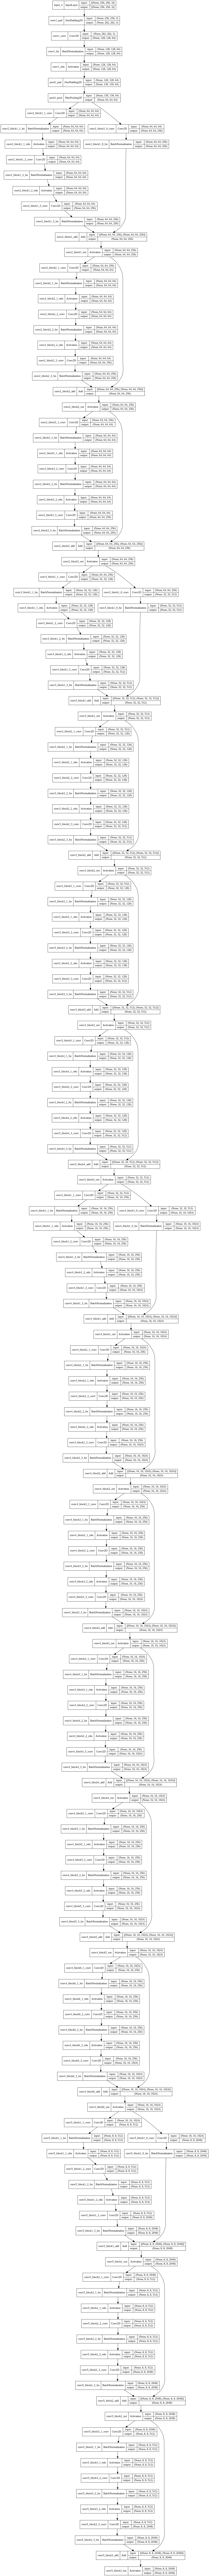

In [11]:
tf.keras.utils.plot_model(res50,show_shapes=True)

# Compile:

Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics 

In [ ]:
#Compile
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])

# Fit the model

In [ ]:
EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE


#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS ,validation_data=test_dataset)

Epoch 1/30
46/46 [==============================] - 55s 662ms/step - loss: 0.5357 - accuracy: 0.3583 - val_loss: 0.2065 - val_accuracy: 0.8320
Epoch 2/30
46/46 [==============================] - 31s 643ms/step - loss: 0.1145 - accuracy: 0.3992 - val_loss: 0.1344 - val_accuracy: 0.8362
Epoch 3/30
46/46 [==============================] - 29s 635ms/step - loss: 0.0502 - accuracy: 0.4106 - val_loss: 0.0636 - val_accuracy: 0.8362
Epoch 4/30
46/46 [==============================] - 29s 637ms/step - loss: 0.0304 - accuracy: 0.4089 - val_loss: 0.0480 - val_accuracy: 0.8362
Epoch 5/30
46/46 [==============================] - 29s 637ms/step - loss: 0.0222 - accuracy: 0.4091 - val_loss: 0.0528 - val_accuracy: 0.8362
Epoch 6/30
46/46 [==============================] - 29s 634ms/step - loss: 0.0184 - accuracy: 0.4094 - val_loss: 0.0958 - val_accuracy: 0.8362
Epoch 7/30
46/46 [==============================] - 29s 635ms/step - loss: 0.0164 - accuracy: 0.4054 - val_loss: 0.0865 - val_accuracy: 0.8362

# Predict


In [ ]:
def show_predictions(dataset, num=10):
    for image, mask in dataset.take(num):
        #Prediction
        pred_mask = model.predict(image)
        display([image[1], mask[1], pred_mask[1]])
        #plt.imshow(1 - pred_mask[0,:,:,0],cmap='gray')

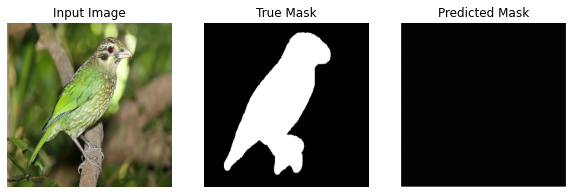

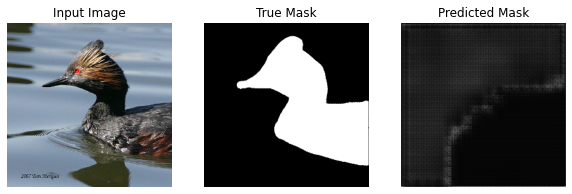

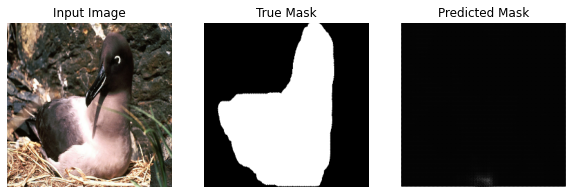

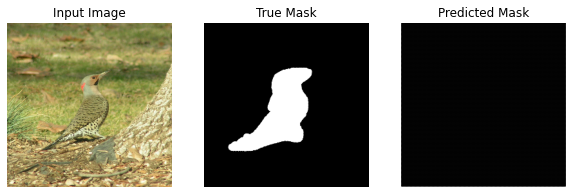

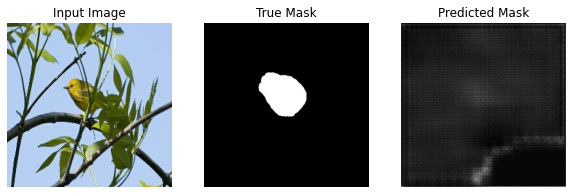

In [ ]:
show_predictions(train_dataset,5)

# **D_LinkNet:**

# Preprocessing data


In [3]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#### put image size ###

image_size = 256

In [4]:
def normalize(input_image, input_mask):
  input_image = input_image/255.
  input_mask = input_mask / 255.
  return input_image, input_mask




**Complete the required items:**

Flip images from right to left

Flip images from up to down

adjust brightness image with delta = 0.5

central crop image with value = 0.5

In [5]:
@tf.function
def load_image_train(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])
  if tf.random.uniform(()) > 0.5:
    #### put your code ###
        
    # flip images from right to left
    input_image = tf.image.flip_left_right(input_image)
    input_mamsk = tf.image.flip_left_right(input_mask)

    # Flip images from up to down
    input_image = tf.image.flip_up_down(input_image)
    input_mask = tf.image.flip_up_down(input_mask)

    # adjust brightness image with delta = 0.5
    input_image = tf.image.adjust_brightness(input_image,delta = 0.5)
    input_mask = tf.image.adjust_brightness(input_mask,delta = 0.5)

    # central crop image with value = 0.5
    inut_image = tf.image.central_crop(input_image,central_fraction = 0.5)
    inut_mask = tf.image.central_crop(input_mask,central_fraction = 0.5)

    # resize 
    input_image = tf.image.resize(input_image,[image_size,image_size])
    input_mask = tf.image.resize(input_mask,[image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [6]:
def load_image_test(datapoint):
  #Resize
  
  input_image = tf.image.resize(datapoint['image'], [image_size,image_size])
  input_mask = tf.image.resize(datapoint['segmentation_mask'], [image_size,image_size])

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [7]:

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [8]:
def display(display_list):
  plt.figure(figsize=(10, 10))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i>0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap='gray')
    else:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

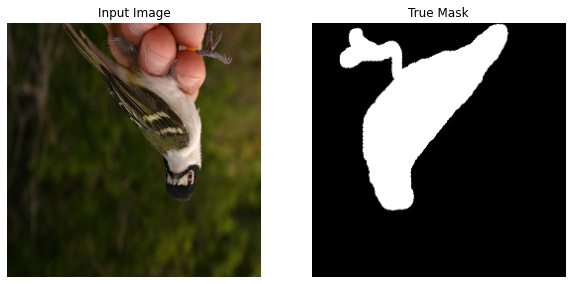

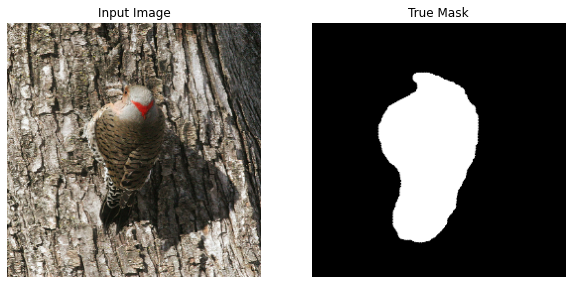

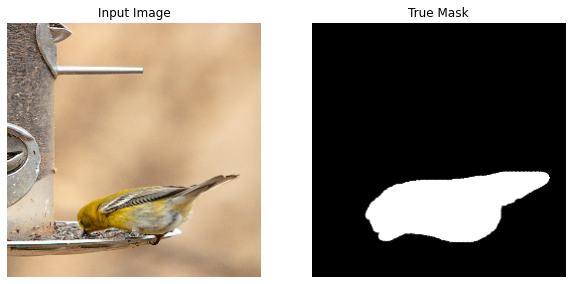

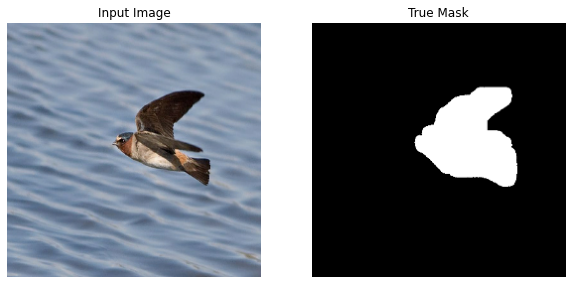

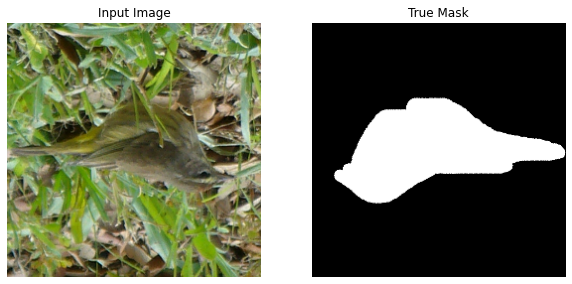

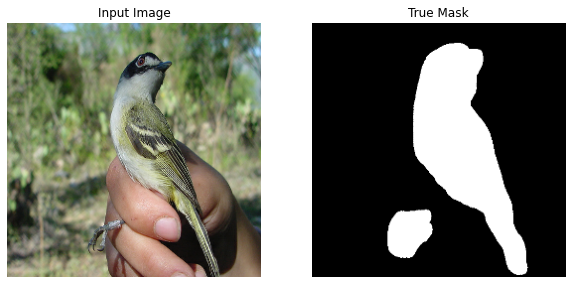

In [9]:
for image, mask in train.take(6):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

# D_linknet architecture:

https://sci-hub.se/10.1109/CVPRW.2018.00034



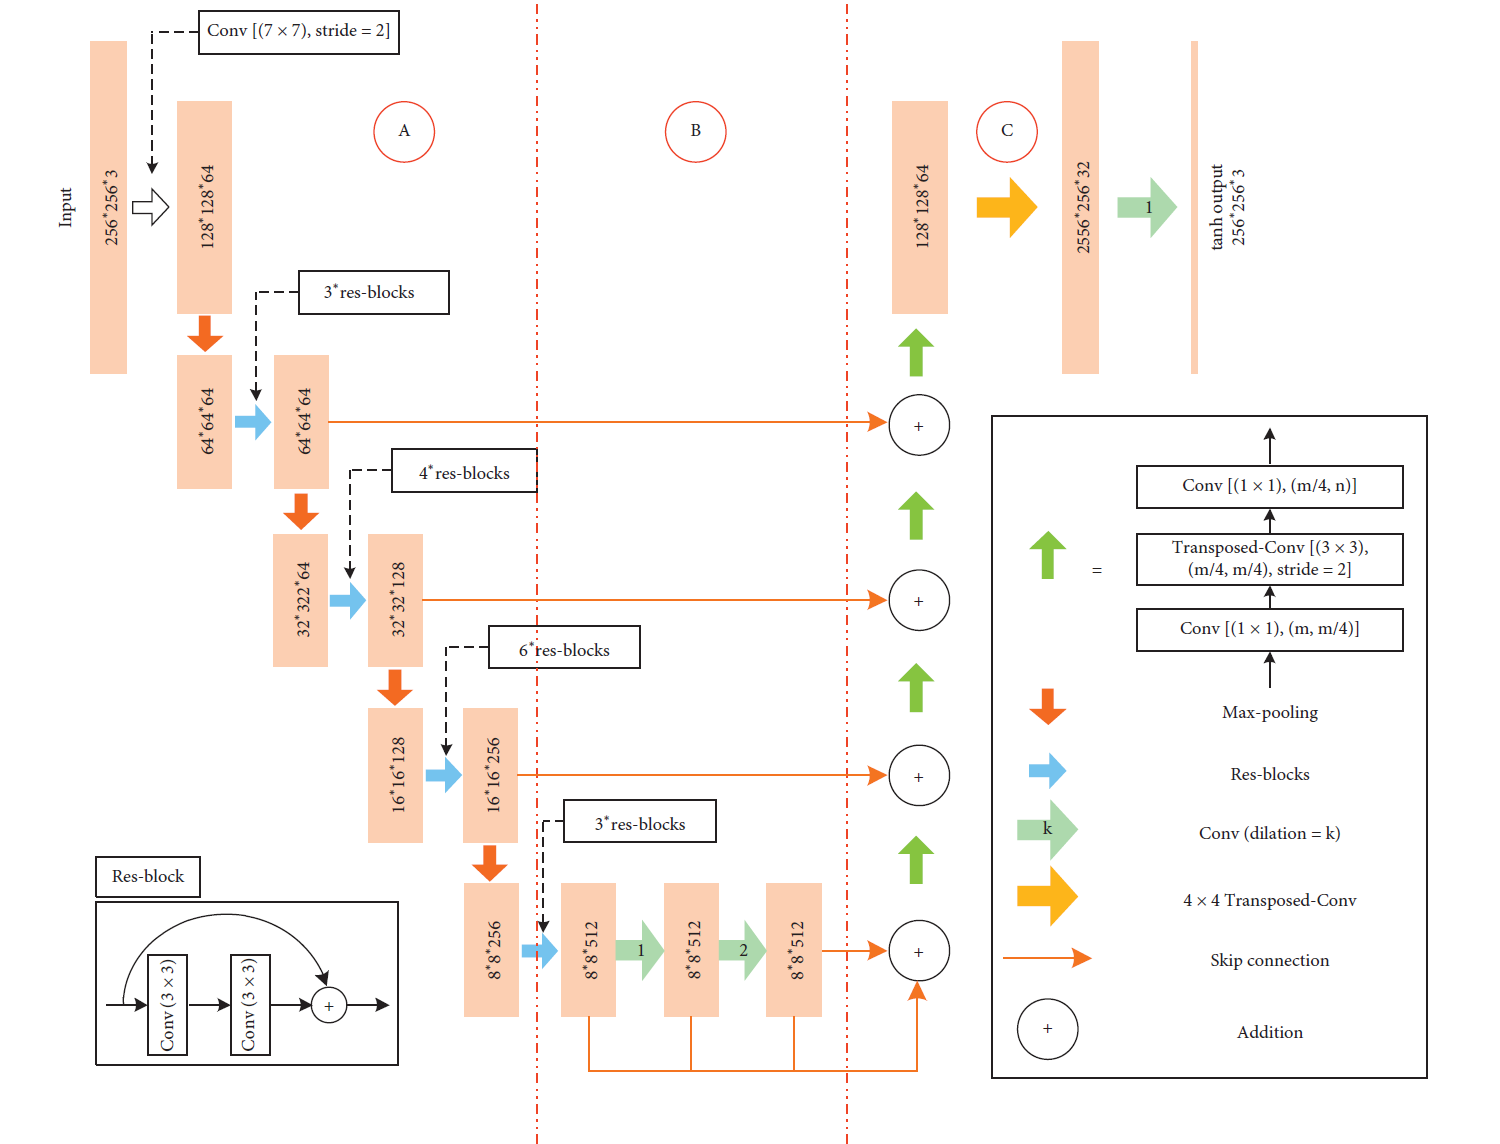


You can use the following link to get acquainted with convolution2d_transpose


https://keras.io/api/layers/convolution_layers/convolution2d_transpose/


In [57]:
# define a D_linknet
 
##### Part A #####
inputs = Input(shape=(image_size,image_size,3))
Conv2D_1 = Conv2D(filters=64,kernel_size=(7,7),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(inputs)
MaxPool_1 = MaxPool2D()(Conv2D_1)
res_1 = residual_module(MaxPool_1,64)
res_2 = residual_module(res_1,64)
res_3 = residual_module(res_2,64) # connection 1
MaxPool_2 = MaxPool2D()(res_3)
res_4 = residual_module(MaxPool_2,128)
res_5 = residual_module(res_4,128)
res_6 = residual_module(res_5,128)
res_7 = residual_module(res_6,128) # connection 2
MaxPool_3 = MaxPool2D()(res_7)
res_8 = residual_module(MaxPool_3,64)
res_9 = residual_module(res_8,256)
res_10 = residual_module(res_9,256)
res_11 = residual_module(res_10,256)
res_12 = residual_module(res_11,256)
res_13 = residual_module(res_12,256) # connection 3
MaxPool_4 = MaxPool2D()(res_13)
res_14 = residual_module(MaxPool_4,512)
res_15 = residual_module(res_14,512)
res_16 = residual_module(res_15,512) # C1

##### Part B #####
Dilation_1 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(res_16) # C2
Dilation_2 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=2)(Dilation_1) # C3

##### Part C #####
Add_1 = add([res_16,Dilation_1,Dilation_2])
Up_green_1 = Up_green(Add_1,256)
Add_2 = add([Up_green_1,res_13])
Up_green_2 = Up_green(Add_2,128)
Add_3 = add([Up_green_2,res_7])
Up_green_3 = Up_green(Add_3,64)
Add_4 = add([Up_green_3,res_3])
Up_green_4 = Up_green(Add_4,32)
Conv2D_2 = Conv2D(filters=64,kernel_size=(1,1),padding = 'same',kernel_initializer='he_normal')(Up_green_4)

Conv2D_3 = Conv2DTranspose(filters=32,kernel_size=(4,4),padding = 'same',kernel_initializer='he_normal',strides=2)(Conv2D_2)

#reshaped = Reshape((256, 256, 32))(Conv2D_2)

Dilation_3 = Conv2D(filters=3,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(Conv2D_3) 
outputs_tmp = Conv2D(filters=1,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(Dilation_3)
outputs = tf.keras.activations.tanh(outputs_tmp)

model = tf.keras.Model(inputs,outputs)

tf.keras.utils.plot_model(model,show_shapes=True)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_43 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_209 (Conv2D)            (None, 128, 128, 64  9472        ['input_43[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_209[0][0]']             
                                                                                            

In [56]:
# function for creating an identity residual module
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    if(layer_in.shape[-1] != n_filters):
        merge_input = Conv2D(n_filters,(1,1),padding='same',activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    # add filters, assumes filters/channels last
    layer_out = add([conv2, merge_input])
    # activation function
    layer_out = Activation('relu')(layer_out)
    return layer_out

In [44]:
def Up_green(layer_in,m):
    # conv1
    conv1 = Conv2D(m/4, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    # T Conv 2
    Conv2 = Conv2DTranspose(filters=m/4,kernel_size=(3,3),strides=(2,2),padding = 'same',kernel_initializer='he_normal')(conv1)
    # Conv 3
    conv3 = Conv2D(m, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(Conv2)

    return conv3 

# Use ResNet50 For D-link Net

In [58]:
from keras.activations import sigmoid

inputs = Input(shape=(image_size,image_size,3))

res50 = tf.keras.applications.ResNet50(include_top=False,weights=None,input_shape=(256,256,3),input_tensor=inputs)
res_50_out = res50.get_layer('conv5_block3_out').output
res_50_out = Conv2D(512,1,padding='same',activation='relu')(res_50_out)

Dilation_1 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(res_50_out) # C2
Dilation_2 = Conv2D(filters=512,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=2)(Dilation_1) # C3

##### Part C #####
Add_1 = add([res_50_out,Dilation_1,Dilation_2])
Up_green_1 = Up_green(Add_1,256)

res_13 = res50.get_layer('conv4_block1_add').output
res_13 = Conv2D(256,1,padding='same',activation='relu')(res_13)

Add_2 = add([Up_green_1,res_13])
Up_green_2 = Up_green(Add_2,128)

res_7 = res50.get_layer('conv3_block4_add').output
res_7 = Conv2D(128,1,padding='same',activation='relu')(res_7)
Add_3 = add([Up_green_2,res_7])
Up_green_3 = Up_green(Add_3,64)

res_3 = res50.get_layer('conv2_block3_add').output
res_3 = Conv2D(64,1,padding='same',activation='relu')(res_3)
Add_4 = add([Up_green_3,res_3])
Up_green_4 = Up_green(Add_4,32)
Conv2D_2 = Conv2D(filters=64,kernel_size=(1,1),padding = 'same',kernel_initializer='he_normal')(Up_green_4)

Conv2D_3 = Conv2DTranspose(filters=32,kernel_size=(4,4),padding = 'same',kernel_initializer='he_normal',strides=2)(Conv2D_2)

#reshaped = Reshape((256, 256, 32))(Conv2D_2)

Dilation_3 = Conv2D(filters=3,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(Conv2D_3) 

outputs_tmp = Conv2D(filters=1,kernel_size=(3,3),padding = 'same',kernel_initializer='he_normal',dilation_rate=1)(Dilation_3)
outputs = tf.keras.activations.tanh(outputs_tmp)

model = tf.keras.Model(inputs,outputs)

tf.keras.utils.plot_model(model,show_shapes=True)

model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_44[0][0]']               
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

# Compile the model
Use Adam optimizer with learning rate 0.001 and BinaryCrossentropy with from_logits=True

Set accuracy for metrics

In [33]:
#Compile
model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.001), loss = keras.losses.BinaryCrossentropy(from_logits=False), metrics = ['accuracy'])

# Fit the model

In [35]:
EPOCHS = 30
VAL_SUBSPLITS = 5 
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

#Complete with train_data, epochs, steps_per_epoch, validation_steps, validation_data
history = model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH,validation_steps=VALIDATION_STEPS ,validation_data=test_dataset)

Epoch 1/30
46/46 [==============================] - 55s 662ms/step - loss: 0.5357 - accuracy: 0.3583 - val_loss: 0.2065 - val_accuracy: 0.8320
Epoch 2/30
46/46 [==============================] - 31s 643ms/step - loss: 0.1145 - accuracy: 0.3992 - val_loss: 0.1344 - val_accuracy: 0.8362
Epoch 3/30
46/46 [==============================] - 29s 635ms/step - loss: 0.0502 - accuracy: 0.4106 - val_loss: 0.0636 - val_accuracy: 0.8362
Epoch 4/30
46/46 [==============================] - 29s 637ms/step - loss: 0.0304 - accuracy: 0.4089 - val_loss: 0.0480 - val_accuracy: 0.8362
Epoch 5/30
46/46 [==============================] - 29s 637ms/step - loss: 0.0222 - accuracy: 0.4091 - val_loss: 0.0528 - val_accuracy: 0.8362
Epoch 6/30
46/46 [==============================] - 29s 634ms/step - loss: 0.0184 - accuracy: 0.4094 - val_loss: 0.0958 - val_accuracy: 0.8362
Epoch 7/30
46/46 [==============================] - 29s 635ms/step - loss: 0.0164 - accuracy: 0.4054 - val_loss: 0.0865 - val_accuracy: 0.8362

# Predict


In [38]:
def show_predictions(dataset, num=10):
  for image, mask in dataset.take(num):
      #Prediction
      pred_mask = model.predict(image) 
      display([image[0], mask[0], pred_mask[0]])

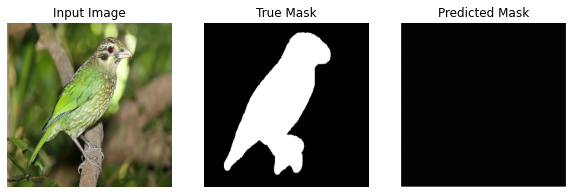

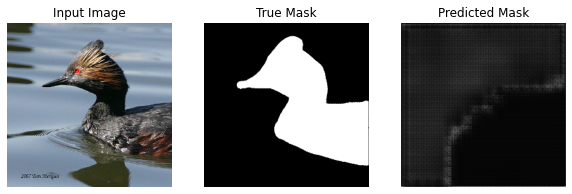

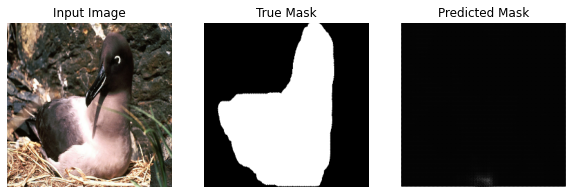

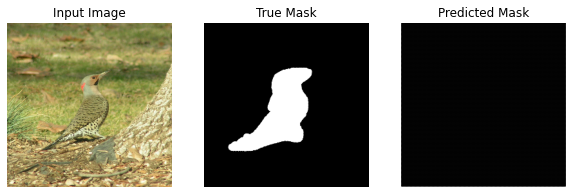

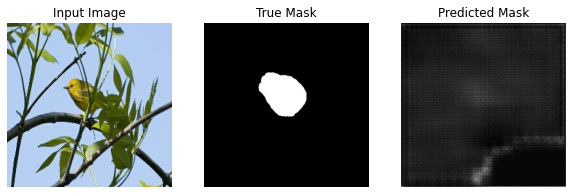

In [ ]:
show_predictions(train_dataset,5)